In [1]:
# Commom directives
%matplotlib inline
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt

# from local dir
from detect_peaks import detect_peaks

<a id='tableofcontent'></a>

# Análise de Sinais de Eletrocardiograma
## Antônio Horta Ribeiro
Índice
------------------
* [I - Introdução](#intro)
* [II - Pré-processamento e Condicionamento do Sinal](#preprocessing)
    * [1. Interferência da Rede Elétrica](#powerline)
        * [1.1) Filtro *Notch*](#notch)
            * [a) Resposta em frequência ](#notchfreqresp)
            * [b) Aplicação no  sinal do ECG](#notchapply)
        * [1.2) Filtro Adaptativo ("*Incremental Estimation Filter*")](#adaptative)
            * [a) Aplicação no  sinal do ECG](#applyadaptative)
            * [b) Comparação dos métodos](#powerlinecomparative)
    * [2. Flutuações de Baixa Frequência ("*Baseline Wander*")](#baselinewander) 
        * [2.1) Filtro Passa-Altas](#highpass)
            * [a) Resposta em frequência](#highpass)
            * [b) Aplicação no  sinal do ECG](#applyhighpass)
    * [3. Ruído de Alta Frequência](#noise) 
        * [3.1) Filtro Passa-Baixas](#lowpass)
            * [a) Resposta em frequência](#lowpass)
            * [b) Aplicação no  sinal do ECG](#applylowpass)
    * [4. Ruído Muscular](#musclenoise)
    * [5. Comentários](#preprocessingcoments)
* [III - Extração das *Features* do ECG](#detection)
    * [1 Detecção do complexo QRS ](#detection)
        * [1.1) Realçando o complexo QRS ](#detection)
            * [a) Explicação do método](#detection)
            * [b) Relação no domínio da Frequência](#detection)
            * [c) Exemplo de aplicação](#QRSex)
        * [1.2) Detecção do pico de R](#findRpeaks)
            * [a) Procedimento](#findRpeaks)
            * [b) Exemplo de aplicação](#findRpeaks_example)
            * [c) Comentários](#findRpeaks_coments)
            * [d) Sequência de autocorrelação](#findRpeaks_acs)
            * [e) Exemplo da aplicação - autocorrelação](#findRpeaks_acs_example)
            * [f) Características médias do sinal do eletrocardiograma](#findRpeaks_mean)
            * [g) Usando o período médio para encontrar o *threshold* de altura](#findRpeaks_height_thr)
            * [h) Escolha dos parâmetros para detecção do pico de R](#findRpeaks_params)
        * [1.3) Detecção do início e do final do complexo QRS](#QRSonsetoffset)
            * [a) Sinal Analítico](#QRSonsetoffset)
            * [b) Transformada Hilbert e os Sinais Analíticos](#QRSonsetoffset)
            * [c) Envelope de Sinais](#QRSonsetoffset)
            * [d) Envelope da derivada do sinal do ECG](#QRSonsetoffset)
            * [e) Explicação do método](#QRSonsetoffsetalgorithm)
            * [f) Exemplo de aplicação](#QRSonsetoffset_example)
            * [g) Escolha dos parâmetros](#QRSonsetoffset_params)
        * [1.4) Detecção dos picos de Q e de S](#findQSpeaks)
            * [a) Explicação](#findQSpeaks)
            * [b) Exemplo de Aplicação](#findQSpeaks_ex)
        * [1.5) Comentários Finais sobre a Detecção do Complexo QRS](#QRSfinalcoments)
            * [a) Resumo do método visto até aqui](#QRSfinalcoments)
            * [b) Varias topologias do complexo QRS](#QRSfinalcoments)
            * [c) Um possível sistema mais geral](#QRSfinalcoments)
    * [2) Detecção das ondas P e das ondas T](#PTwaves)
        * [2.1) Condicionamento do Sinal](#PTwaves)
            * [a) Explicação do método](#PTwaves)
            * [b) Exemplo de aplicação](#PTwaves_cond_ex)
        * [2.2) Detecção das ondas P e Q](#PTwaves_detect)
    * [3) Extração dos Parâmetros](#param)
        * [3.1) Formando um complexo P-QRS-T representativo](#param)
        * [3.2) Observação](#obs)
        * [3.3) Medições de Tempos e Amplitudes](#obs)
* [IV - Conclusão](#concl)
* [Agradecimentos](#agrad)
* [Referências](#ref)    
        

<a id='intro'></a>

# I - Introdução

Eletrocardiografia é o processo de gravar a atividade elétrica do coração por um período de tempo (normalmente $10$ segundos) usando 
eletrodos colocados sobre a pele.
Esses eletrodos captam pequenas diferenças de potêncial causadas pela despolarização e repolarização
durante cada batimento cardiaco e essas informações são utilizadas por clínicos
para diagnóstico de doenças.

Tradicionalmente 10 eletrodos são colocados sobre a caixa toráxica, pernas e braços
do paciente e a partir desses eletrodos a magnitude do potêncial elétrico é medido de 12 angulos diferentes ("12 derivações").
O sinal das 12 derivações imprimido por um aparelho de eletrocardiografia para um ECG normal está mostrado 
abaixo. Nessas impressões quadriculadas, um quadradinho pequeno de 
$1~\text{mm}\times 1~\text{mm}$ representa $0.1~\text{mV} \times 0.04~ \text{segundos}$.

--------------------------
![normalecg](img/normalecg.jpg)

---------------------------

O invetor do primeiro eletrocardiograma prático, Willen Einthoven, para propósito de identificação,
marcou as maiores deflexões do eletrocardiograma (ECG) com os índices $P$, $Q$, $R$, $S$ e $T$. Os picos
de um ECG e as letras correspondentes a estes estão mostrados na figura abaixo. 

------------------------
![pqrst](img/pqrst.JPG)

---------------------------

Durante cada batimento cardiáco de um coração saudavel os seguintes
eventos podem ser detectados no ECG :

* Despolarização atrial (Onda $P$);
* Despolarização ventricular (Complexo $QRS$);
* Repolarização ventricular (onda $T$);

------------------------
![events](img/events.png)

---------------------------

Nesse trabalho estudaremos a análise computadorizada do eletrocardiograma.  De
acordo com [[3]](#ref), essa análise pode ser dividida em duas grandes etapas

1. **Processamento e medição do sinal**: que envolve o pré-processamento, a detecção de pontos de interesse e a realização de medições no eletrocardiograma.
2. **Interpretação**: que seria responsável por procurar significância clínica nas medidas obtidas na primeira etapa.

O foco desse trabalho será a etapa de **Processamento e medição do sinal**, para a qual alguns dos métodos
descritos na literatura serão implementados em Python e testados em sinais reais de ECG.

<a id='preprocessing'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

# II - Pré-processamento e Condicionamento do Sinal

Anormalidades no eletrocardiograma que não resultam da atividade elétrica do coração são definidos como artefatos. Os artefatos não são incomuns em pacientes submetidos à monitoração ECG. Eles alteram a morfologia do ECG e podem conduzir a erros diagnósticos, tanto falso positivos, mimetizando arritmias, quanto falso negativos, ocultando achados condizentes com doença cardíaca.

Dentre os principais artefatos presentes destacam-se: Interferência da rede elétrica; Flutuações de baixa frequência (*Baseline Wander*); Ruído de alta frequência e ruído muscular. Nessa parte do trabalho cada uma dessas fontes de disturbio serão discutidas.

<a id='powerline'></a>

##  1. Interferência da Rede Elétrica

A interferência da rede elétrica é uma fonte comum de disturbio no sinal do ECG. Essa interferência é
caracterizada por componentes em $60 \text{Hz}$ (e, em alguns casos, nos seus harmonicos).

**Exemplo:**
Na figura gerada abaixo está mostrado, à esquerda, um período do eletrocardiograma e, à direita, uma estimativa
para a densidade de potência espectral do sinal (usando o periodograma de Welch). A componente acentuada
que ocorre na frequência de 60 Hz é causada pela interferencia da rede.

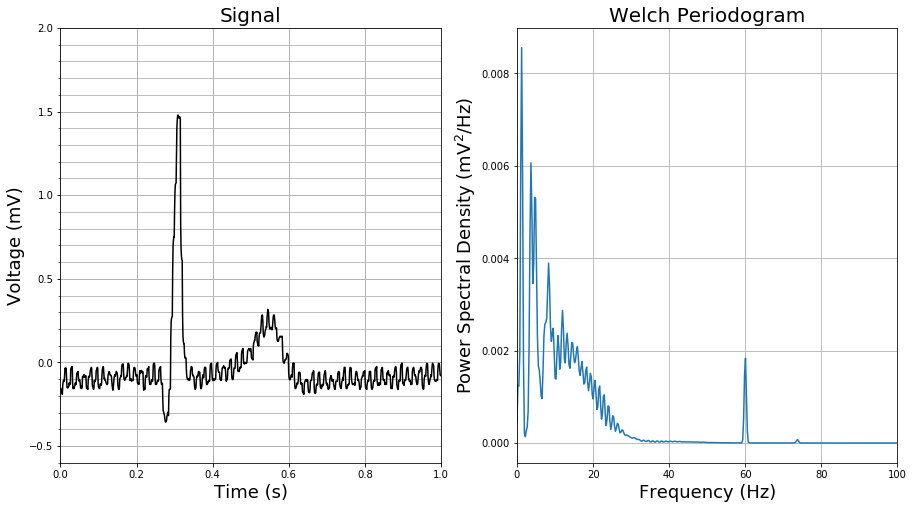

In [2]:
# Load signal
sample1 = np.load("data/sample1.npz")
x = sample1['x']
fs = sample1['fs']

# Generate time vector
t = np.arange(len(x))*1/fs

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs, window='hamming', nperseg=2000, nfft=4096, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0, 100])

plt.show()

Serão estudadas duas formas de lidar com esse tipo de interferência: 

- Filtros *notch*;
- Filtros adaptativos.

essas duas soluções serão discutidas a seguir.


<a id='notch'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.1) Filtro *Notch*
Um filtro *notch* é um filtro rejeita-faixa com uma banda de rejeição estreita (alto fator de qualidade). Ele
pode ser usado para remover as frequências de $60 \text{Hz}$ sem interferir com as demais componentes do sinal.
O projeto de filtros notch é descrito em  [[1]](#ref). A seguir está implementada
uma função que calcula os coeficientes do filtro *notch* baseado na largura da banda de rejeição desejada e 
na frequência que deseja-se eliminar.

In [3]:
# Function for notch filter Design 
def iirnotch(w0, bw, ab=3):
    """
    Design second-order IIR notch digital filter.

    Parameters
    ----------
    w0 : float
        A scalar that must satisfy  0 < w0 < 1. For
        notch filters, w0 is the normalized frequency 
        to remove from the filtered signal (w0 = 1 
        corresponds to half of the sample frequency).
    bw : float
        Filter bandwidth.
    ab : float, optional
        Atenuation in decibels. By default, `ab`
        is 3. So the atenuation is -3 dB or -10*log10(1/2) dB.

    Returns
    -------
    b, a : ndarray, ndarray
        Numerator (`b`) and denominator (`a`) polynomials
        of the IIR filter.
        
    Notes
    -----
    The quality factor (Q factor) for the filter is related to the 
    filter bandwidth by Q = w0/bw (for the default value of `ab`).
    
    References
    ----------
    .. [1] Sophocles J. Orfanidis, "Introduction To Signal Processing",
           Prentice-Hall, 1996
    """

    # Normalize inputs
    bw = bw*np.pi
    w0 = w0*np.pi

    # Compute atenuation from ab
    gb = 10.0**(-ab/20.0)

    # Compute beta: formula 11.3.4 from reference [1]
    beta = (np.sqrt(1.0-gb**2.0)/gb)*np.tan(bw/2.0)

    # Compute gain: formula 11.3.6 from reference [1]
    gain = 1.0/(1.0+beta)

    # Compute numerator (`b`) and denominator (`a`):
    # formula 11.3.7 from reference [1]
    b = gain*np.array([1.0, -2.0*np.cos(w0), 1.0])
    a = np.array([1.0, -2.0*gain*np.cos(w0), (2.0*gain-1.0)])

    return (b, a)

<a id='notchfreqresp'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### a) Reposta em frequência
Dada uma frequência de amostragem de $f_s = 1000\text{Hz}$ a resposta em frequência de um filtro *notch*
para eliminar a componente de $60 \text{Hz}$ está mostrada abaixo para um fator de qualidade $Q = 30$.

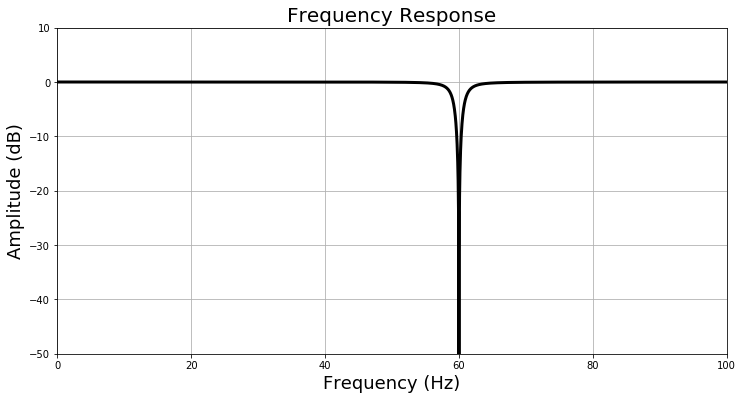

In [4]:
fs = 1000.0  # Hz
f0 = 60.0  # Hz
q = 30.0  # Quality factor

w0 = f0/(fs/2)
bw = w0/q

# Design notch filter
b, a = iirnotch(w0, bw)

# Frequency response
w, h = sgn.freqz(b, a, 2**14)

# Generate frequency axis
freq = w*fs/(2*np.pi)

#plot
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(freq, 20*np.log10(abs(h)), color='black', linewidth=3)
ax.grid()
ax.set_title("Frequency Response", fontsize=20)
ax.set_ylabel("Amplitude (dB)", fontsize=18)
ax.set_xlabel("Frequency (Hz)", fontsize=18)
ax.axis([0, 100, -50, 10])
plt.show()

<a id='notchapply'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Aplicação no  sinal do ECG
Considere o exemplo mostrado no inicio da [seção 5.1](#powerline), abaixo está mostrada o resultado de aplicar o
filtro *notch* projetado na [seção anterior](#notchfreqresp) a esse sinal. Para garantir que não haja distorção na fase será usada a filtragem bidirecional 
(função ```filtfilt```).

Tanto olhando o periodograma quanto o sinal é possível perceber que a componente de $60\text{Hz}$ foi eliminada
do sinal. Apesar disso, componentes de alta frequência ainda contaminam o sinal, elas serão discutidas nas
seções subsequentes.

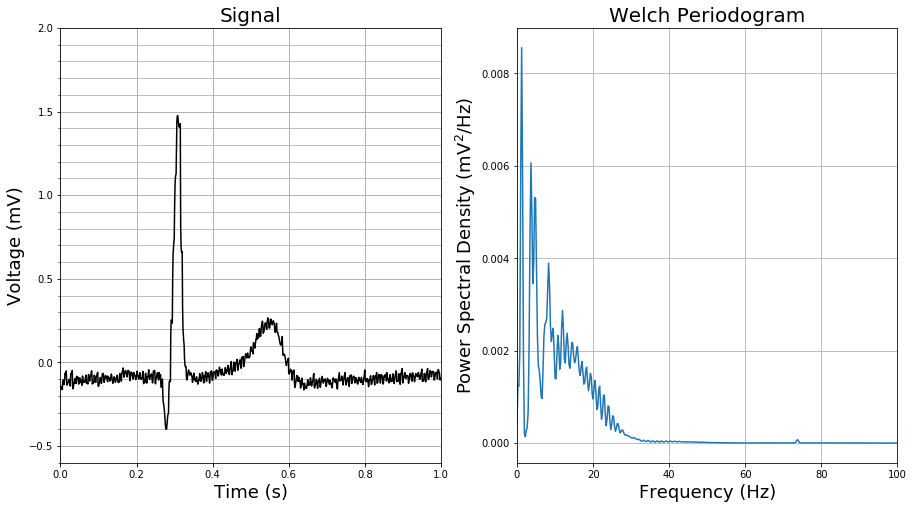

In [5]:
# Apply notch filter to the signal
x_notch  = sgn.filtfilt(b, a, x)
# Compute welch periodogram
freq, Pxx_notch = sgn.welch(x_notch, fs, window='hamming', nperseg=2000, nfft=4096, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x_notch[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx_notch)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0, 100])

plt.show()

<a id='adaptative'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.2) Filtro Adaptativo ("*Incremental Estimation Filter*")

Nessa abordagem proposta por [[2]](#ref), define-se um sinal de referência $w[n]$ que tenta captar a interferência em uma frequência $f_0$. 
Com o conhecimento da interferência $w[n]$ nos instantes passados tenta-se fazer uma predição *a priori* da componente de ruído no instante atual $n$. Essa predição é dada por:

$$v[n] = 2\text{cos}\left(\frac{2\pi f_0}{f_s}\right)w[n-1] - w[n-2]$$

onde $f_s$ é a frequência de amostagem. Uma medida da qualidade da estimativa $v[n]$ pode ser dada 
pela formula a seguir:

$$e[n] = (x[n] - v[n]) - (x[n-1] - w[n-1])$$

utiliza-se esse erro $e[n]$ para calcular uma estima *a posteriori* da componente de ruído:

$$w[n] = v[n] + \delta ~ sgn(e[n])$$

onde $\delta$ é uma constante escolhida heuristicamente. O valor de $w[n]$ é então subtraído 
do sinal:

$$y[n] = x[n] - w[n]$$.

e $y[n]$ é a saída do filtro.

Será usado $\delta = 1.25\mu V$ que é o valor original proposto por (Mortara, 1977).

In [6]:
def incrementalestfilter(x, w0, delta=0.00125):
    """
    Apply adaptative non-linear filter to signal `x`
    in order to remove the normalized frequency `w0`

    Parameters
    ----------
    x : array_like
        An one dimensional array containing the signal
        to be filtered.
    w0 : float
        A scalar that must satisfy  0 < w0 < 1,
        w0 is the normalized frequency to remove 
        from the filtered signal (w0 = 1 corresponds
        to half of the sample frequency).
    delta : float
        increment parameter. By default delta = 0.00125.
    
    Returns
    -------
    y : array_like
        The filtered output, an array with the same shape as x.
    
    References
    ----------
    .. [1] Mortara, David W. "Digital filters for ECG signals." 
           Computers in Cardiology (1977): 511-514
    """

    # Make sure x is a numpy array 
    x = np.asarray(x, np.float)

    # Initialize output y and auxiliar variables
    y = np.zeros(x.shape)
    w = np.zeros(x.shape)
    e = np.zeros(x.shape)
    v = np.zeros(x.shape)

    # Apply filter
    for n in range(2, len(x)):
        v[n] = 2*np.cos(np.pi*w0)*w[n-1] - w[n-2]
        e[n] = (x[n] - v[n]) - (x[n-1] - w[n-1])
        w[n] = v[n] + delta * np.sign(e[n])
        y[n] = x[n] - w[n]

    return y

<a id='applyadaptative'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### a) Aplicação no sinal do ECG
Considere o exemplo mostrado no inicio da [seção 5.1](#powerline), abaixo está mostrada o resultado de aplicar o
filtro adaptativo a esse sinal. Note que a frequência de $60 Hz$ foi atenuada, mas não foi totalmente removida.

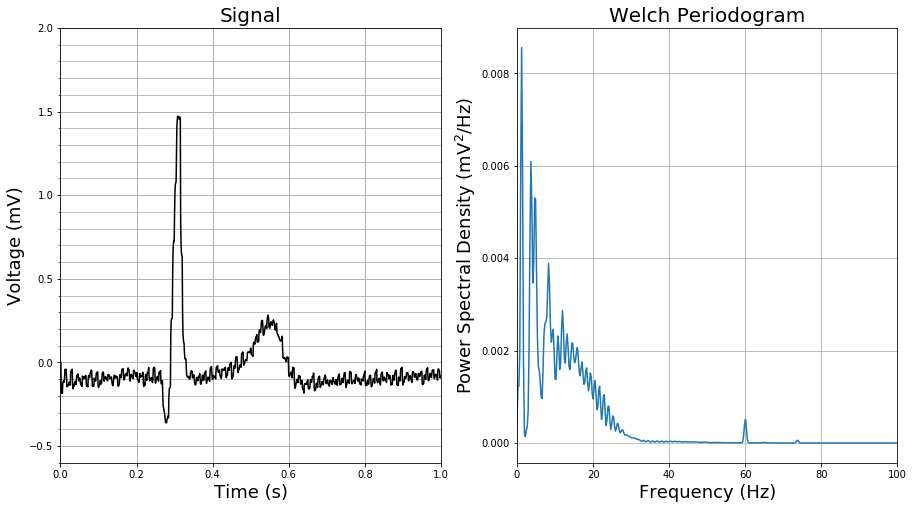

In [7]:
# Apply notch filter to the signal
x_inc  = incrementalestfilter(x, w0, 0.00125)
# Compute welch periodogram
freq, Pxx_inc = sgn.welch(x_inc, fs, window='hamming', nperseg=2000, nfft=4096, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x_inc[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx_inc)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0, 100])

plt.show()

<a id='powerlinecomparative'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Comparaçao dos métodos
As seções [5.1b](#notchapply) e [5.2a](#applyadaptative) ilustram os resultados de aplicar, respectivamente,
o filtro *notch* e o filtro adaptativo no sinal do eletrocardiograma. Em [[3]](#ref), ambos os métodos são descritos
como métodos estabelescidos para remover a interferência da rede elétrica.

Os resultados obtidos por simulação parecem indicar que o uso de filtros *notch* consegue
obter uma maior atenuação do ruído de $60 \text{Hz}$, apesar de que, de acordo com 
(Macfarlane et al., 1989) o filtro adaptativo seria capaz de obter melhores respostas transientes (o que não
foi verificado nesse trabalho).

<a id='baselinewander'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 2. Flutuações de Baixa Frequência ("*Baseline Wander*")
Outra fonte comum de distorção do eletrocardiograma são flutuações de baixa frequência causadas normalmente
pelos movimentos respiratórios ou pela variação da impedância dos eletrodos. A frequência dessas flutuações
geralmente são menores do que $0.5 \text{Hz}$ (de acordo com [[3]](#ref)). O método que será estudado aqui para remover essas oscilações
de baixa frequência será a aplicação de filtros IIR passa-altas. 

**Exemplo:**
Na figura gerada abaixo está mostrado, à esquerda, um eletrocardiograma  contaminado por flutuações de
baixa frequência e, à direita, uma estimativa
para a densidade de potência espectral do sinal (usando o periodograma de Welch). 

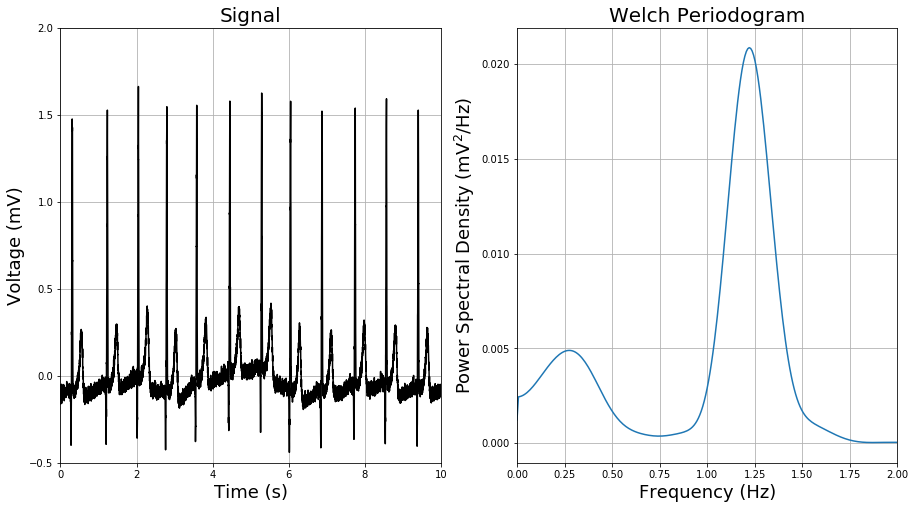

In [8]:
# Get signal from the previous example
x = x_notch

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs, window='hamming', nperseg=5000, nfft=2**17, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t)
ax[0].plot(t, x, 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, Pxx)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].set_xlim([0,2])

plt.show()

<a id='highpass'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 2.1) Filtro Passa-Altas
#### a) Resposta em frequência
Um filtro passa-altas é um filtro que atenua as baixas frequências. Como já foi dito na seção anterior 
as flutuações de baixa frequência que contaminam o eletrocardiograma geralmente estão contidas entre $0$ e $0.5\text{Hz}$. Para filtrar essas flutuações um filtro elíptico de ordem $4$ será usado, ele possui as
seguintes especificações:
* Banda de rejeição : frequências abaixo de $0.8\text{Hz}$
* Banda de passagem :  frequências acima de $0.4\text{Hz}$
* Atenuação na banda de rejeição: $-40\text{dB}$
* *Ripple* na banda de passagem: $0.2 \text{dB}$

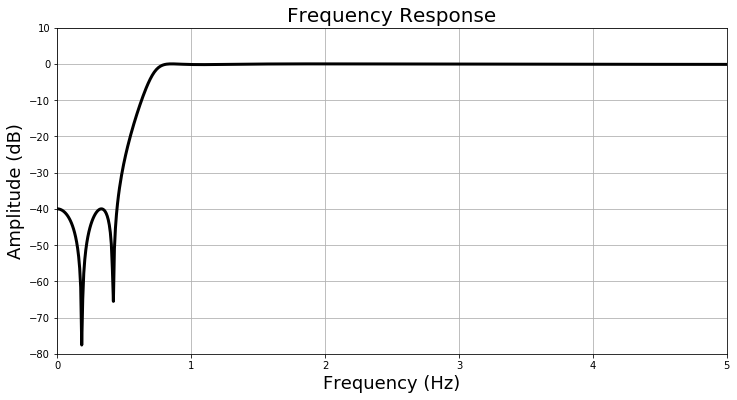

In [9]:
fs = 1000.0  # Hz
fc = 0.8 # Hz, cutoff frequency
fst = 0.4 # Hz, rejection band
rp = 0.2 # dB, ripple in passband
rs = 40 # dB, attenuation in rejection band

wn = fc/(fs/2) # normalized frequency
wst = fst/(fs/2)

filterorder, aux = sgn.ellipord(wn, wst, rp, rs)

# Design high pass filter
b, a = sgn.iirfilter(filterorder, wn, rp, rs, btype='high', ftype='ellip', output='ba')

# Frequency response
w, h = sgn.freqz(b, a, 2**16)

# Generate frequency axis
freq = w*fs/(2*np.pi)

#plot
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(freq, 20*np.log10(abs(h)), color='black', linewidth=3)
ax.grid()
ax.set_title("Frequency Response", fontsize=20)
ax.set_ylabel("Amplitude (dB)", fontsize=18)
ax.set_xlabel("Frequency (Hz)", fontsize=18)
ax.axis([0, 5, -80, 10])
plt.show()

<a id='applyhighpass'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b)  Aplicação no sinal do ECG
Abaixo está mostrado o resultado de aplicar o filtro passa alta no sinal do ECG. Do lado esquerdo encontra-se o 
sinal original e do lado esquerdo encontra-se o sinal após removidas as baixas frequências.

É importante destacar que foi usada a filtragem bidirecional (função ```filtfilt```). Isso tem 
duas consequências: 
1. A atenuação obtida será o dobro daquela para o qual o filtro foi projetado, uma vez que o filtro é aplicado no sentido direto e no sentido reverso.
2. Não haverá distorção na fase.

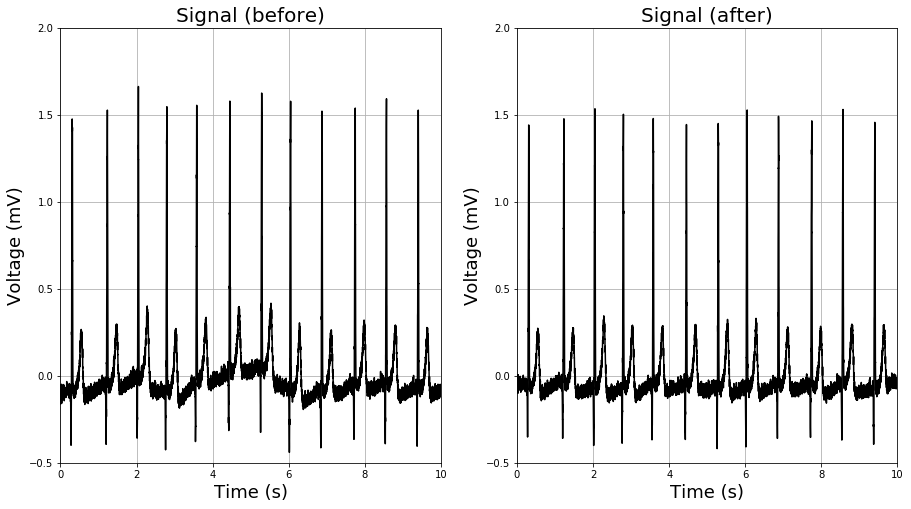

In [10]:
# Apply notch filter to the signal
x_hp  = sgn.filtfilt(b, a, x)
# Compute welch periodogram
freq, Pxx_hp = sgn.welch(x_hp, fs, window='hamming', nperseg=2000, nfft=4096, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t)
ax[0].plot(t, x, 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal (before)", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].grid()

# Plot welch periodogram
ax[1].plot(t, x_hp, 'k')
ax[1].set_ylabel("Voltage (mV)", fontsize=18)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Signal (after)", fontsize=20)
ax[1].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[1].grid()

plt.show()

<a id='noise'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 3. Ruído de Alta Frequência
O eletrocardiograma, como tantos outros sinais elétricos, normalmente é contaminado por ruído de alta frequência.
De acordo com as especificações do IEC a largura de banda requerida do sinal do ECG é de $0.5\text{Hz}$ até $150\text{Hz}$.

Dessa forma, frequências acima de $150Hz$ podem ser filtradas para melhorar a qualidade do sinal.
De fato, como mostraremos a seguir, o sinal do eletrocardiograma pode ser filtrado com uma frequência de corte
mais baixa do que $150\text{Hz}$. Por um lado, isso diminuirá o nível do ruído do sinal, mas, 
por outro, isso irá interferir com características do sinal que podem ser utilizadas para diagnosticos
(esse efeito será estudado a seguir).

Eletrocardiogramas de pacientes com marca-passo podem apresentar espículas de frequência mais alta que $150\text{Hz}$. 
Essas normalmente devem ser detectadas antes da filtragem passa baixas e não serão discutidas nesse trabalho.

**Exemplo:**
Na figura gerada abaixo está mostrado, à esquerda, um eletrocardiograma  e, à direita, uma estimativa
para a densidade de potência espectral do sinal (usando o periodograma de Welch). Note que apesar de
a maior parte da potência espectral estar contida abaixo de $50Hz$ existem algumas componentes de alta
frequência, que em sua maioria são componentes de ruído.

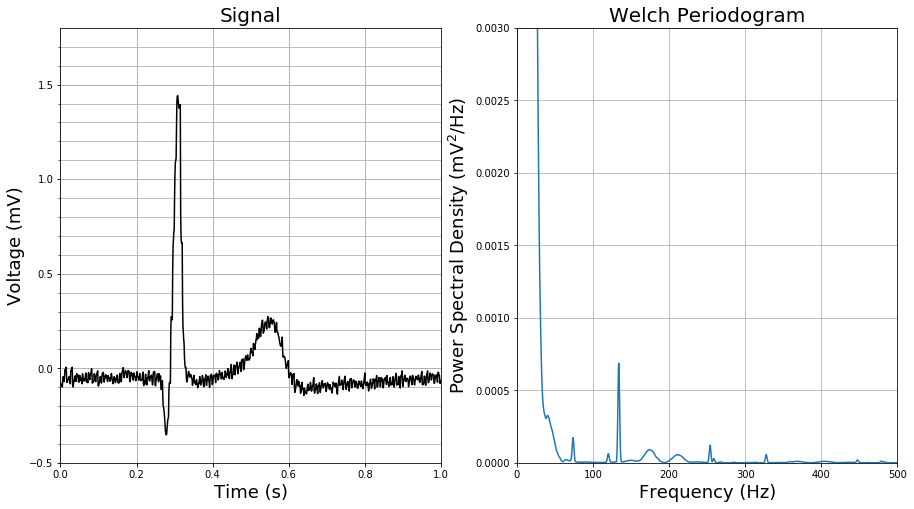

In [11]:
# Get signal from the previous example
x = x_hp

# Compute welch periodogram
freq, Pxx = sgn.welch(x, fs, window='hamming', nperseg=500, nfft=4096, scaling='density')

# Plot signal
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal", fontsize=20)
ax[0].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
ax[0].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
ax[0].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
ax[0].grid(which='minor')
ax[0].grid()

# Plot welch periodogram
ax[1].plot(freq, 10*Pxx)
ax[1].grid()
ax[1].set_title("Welch Periodogram", fontsize=20)
ax[1].set_ylabel("Power Spectral Density (mV$^2/$Hz)", fontsize=18)
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[1].axis([0, 500, 0, 0.003])

plt.show()

<a id='lowpass'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 3.1) Fitro Passa-Baixas
Para eliminar esse ruído de alta frequência será estudada a aplicação de um filtro passa-baixas.
A especificação da IEC requere uma largura de banda de $150\text{Hz}$ para
o eletrocardiograma. 
Para fins de análise, 
compararemos a aplicação de três filtros diferentes:
um filtro com frequência de corte de $150\text{Hz}$ (em **preto**), um filtro 
com frequência de corte de $100\text{Hz}$ (em **<font color="green"> verde </font>**)
e um filtro com frequência de corte de $70\text{Hz}$ (em **<font color="red"> vermelho </font>**).

#### a) Resposta em frequência
A resposta em frequência dos filtros citados acima estão mostradas a seguir.

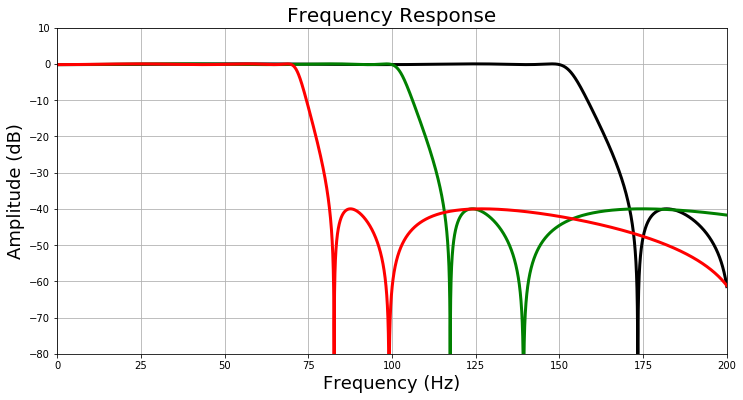

In [12]:
lowpass_cutoff_freq = [150, 100, 70]
color = ["black", "green", "red"]
fig, ax = plt.subplots(1,1, figsize=(12, 6))
b_coef = []
a_coef = []
for i, fc in enumerate(lowpass_cutoff_freq):
    fs = 1000.0  # Hz
    #fc  Hz, cutoff frequency
    fst = fc+0.2*fc # Hz, rejection band
    rp = 0.2 # dB, ripple in passband
    rs = 40 # dB, attenuation in rejection band

    wn = fc/(fs/2) # normalized frequency
    wst = fst/(fs/2)

    filterorder, aux = sgn.ellipord(wn, wst, rp, rs)
    
    # Design lowpass filter
    b, a = sgn.iirfilter(filterorder, wn, rp, rs, btype='low', ftype='ellip', output='ba')

    # save coeficients
    b_coef.append(b)
    a_coef.append(a)
    
    # Frequency response
    w, h = sgn.freqz(b, a, 2**16)

    # Generate frequency axis
    freq = w*fs/(2*np.pi)

    #plot

    ax.plot(freq, 20*np.log10(abs(h)), color=color[i], linewidth=3)
    if i == 0:
        ax.grid()
        ax.set_title("Frequency Response", fontsize=20)
        ax.set_ylabel("Amplitude (dB)", fontsize=18)
        ax.set_xlabel("Frequency (Hz)", fontsize=18)
        ax.axis([0, 200, -80, 10])
    
plt.show()

<a id='applylowpass'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Aplicação no sinal do ECG
A filtragem, usando cada uma das três diferentes
frequências de corte, está mostrada abaixo. É importante destacar que, novamente,
foi usada a filtragem bidirecional para evitar a distorção da fase. 

Alguns comentários sobre o sinal filtrado usando o filtro passa-baixas para as três frequências de 
corte especificadas:
* Quanto mais baixa a frequência de corte maior a atenuação do ruído. É facil verificar que o sinal filtrado com o filtro de frequência de corte de $70 \text{Hz}$ (em **<font color="red"> vermelho </font>**) é significativamente menos "cabeludo" do que o sinal filtrado com o filtro de $150 \text{Hz}$ (em **preto**). 
* Algumas carácterísticas sinal de interesse são atenuadas quando a frequência de corte é menor do que $150 \text{Hz}$. Por exemplo, o pico da onda de R que é $1.4\text{mV}$ para o sinal filtrado com o filtro de $150 \text{Hz}$ (em **preto**) diminuiu para $1.36\text{mV}$ (uma variação de aproximadamente $3\%$) quando consideramos os outros dois sinais em **<font color="green"> verde </font>** e em **<font color="red"> vermelho </font>**. Nesse caso esse efeito não é significativo, porém, em outros caso, componentes significativas para o diagnostico podem ser ocultadas.

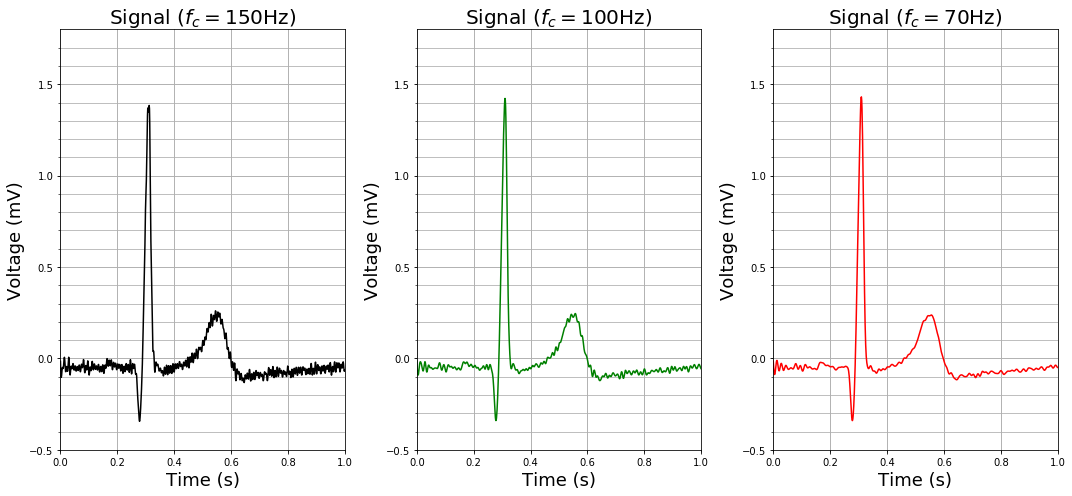

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
tmax = max(t[:1000])


for i, fc in enumerate(lowpass_cutoff_freq):
    # Apply lowpass filter to the signal
    
    x_lp  = sgn.filtfilt(b_coef[i], a_coef[i], x)
    
    # Plot signal
    ax[i].plot(t[:1000], x_lp[:1000],  color=color[i])
    ax[i].set_ylabel("Voltage (mV)", fontsize=18)
    ax[i].set_xlabel("Time (s)", fontsize=18)
    ax[i].set_title("Signal ($f_c ="+str(fc)+"$Hz)", fontsize=20)
    ax[i].axis([0, tmax, round(1.2*min(x),1), round(1.2*max(x),1)])
    ax[i].set_xticks(np.arange(0, tmax+0.2, 0.2), minor=True)
    ax[i].set_yticks(np.arange(round(1.2*min(x),1), round(1.2*max(x),1), 0.1), minor=True)
    ax[i].grid(which='minor')
    ax[i].grid()

plt.tight_layout()
plt.show()

<a id='musclenoise'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 4. Ruído Muscular

Ruído muscular é outra causa de deformação do ECG, ele é causado por descargas elétricas musculares. Esse ruído contém componentes significativa em frequências semelhantes às frequências de interesse do eletrocardiograma e isso o torna difícil de ser eliminado. Veremos na [seção (III-3.1)](#param) um método que pode ajudar a eliminar esse tipo de ruído. 


<a id='preprocessingcoments'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 5. Comentários
* A filtragem passa-baixas e a passa-altas podem ser realizadas por um único filtro passa-faixas isso não foi realizado aqui pois o objetivo era analisar as diferentes componentes de interferência no ECG individualmente.
* No exemplo mostrado o ECG está sendo  amostrado a uma frequência de $1000\text{Hz}$ sendo que a informação relevante para diagnóstico encontra-se na faixa de $0.5\text{Hz}$ a $150\text{Hz}$.  A maioria das companhias que fabrica eletrocardiograma usa faixas de amostragem altas assim pelo seguinte motivo: para ser capaz de detectar espículas de altíssima frequência produzidas pelo marca-passo. Elas geralmente são detectadas antes do pré-processamento do sinal. Uma vez detectada essas espículas, o sinal pode ser filtrado e, se necessário, dizimado para uma frequência mais baixa.

<a id='detection'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

# III - Extração das *Features* do ECG

Uma etapa importante para a analise computadorizada de
um ECG é o reconhecimento dos pontos principais e a medição de segmentos do ECG.
Nessa seção seção discutiremos métodos robustos para detectar alguns 
desses pontos de interesse.

## 1. Detecção do complexo QRS

### 1.1) Realçando o complexo QRS 

#### a) Explicação do método

Uma das características marcantes do complexo QRS é que ele possui
maior quantidade de potência espectral concentrado em altas frequências do que as demais 
ondas do ECG. 

Seja $x[n]$ o sinal do eletrocardiograma original, o procedimento utilizado para destacar
o complexo QRS foi proposto em [[6]](#ref) e está descrito a seguir. Ele segue duas etapas
para realçar o complexo QRS:

* **Primeiro Passo (Cálculo da diferença central)**: Calcula a diferença entre pontos subsequentes como uma forma de aproximar a derivada do sinal:

$$d[n] = x[n+1]-x[n-1]$$

A função de transferência desse sistema é:

$$\frac{D(e^{j\omega})}{X(e^{j\omega})} = e^{j\omega} - e^{-j\omega} = 2~j~sin(\omega)$$

* **Segudo Passo (Transformada Hilbert)**: Aplica a transformada Hilbert $\mathcal{H}$ no sinal $d[n]$. A transformada Hilbert do sinal $d[n]$ equivale a convolução $\mathcal{H}\{d[n]\} = d[n]*h[n]$ onde a transformada de Fourier do núcleo $h[n]$ é:

$$H(e^{j\omega}) = -j~sgn(\omega),~~ - \pi\le \omega \le \pi$$

O conjunto dessas duas operações está resumido no diagrama de blocos abaixo:

------------------------------
![QRSenhance](img/QRSenhance.png)

------------------------------

#### b) Relação no domínio da frequência

De tal forma que a relação entre $y[n]$ e $x[n]$ no domínio da frequência pode ser descrita por:

$$\frac{Y(e^{j\omega})}{X(e^{j\omega})} = \big(2~j~sin(\omega)\big)\big(-j~sgn(\omega)\big)$$

No intervalo de $- \pi\le \omega \le \pi$ temos que:

$$\frac{Y(e^{j\omega})}{X(e^{j\omega})} = 2\big|sin(\omega)\big|,~~ - \pi\le \omega \le \pi$$

A resposta em frequência desse sistema está mostrada a seguir, com o eixo das absiças dado em função de uma
frequência $f$, onde: 

$$f = \frac{\omega}{2\pi}f_s$$

e a frequência de amostragem será $f_s=1000Hz$ (como usado em todos os exemplos da [seção II](#preprocessing)).
Como já foi dito o conteúdo espectral do ECG encontra-se concentrado entre $0.5Hz$ e $150Hz$. Note que nessa faixa
de frequência, o ganho cresce quase que linearmente com a frequência. Dessa forma o complexo QRS, que possui frequências mais altas será realçado enquanto as demais ondas do ECG são atenuadas.

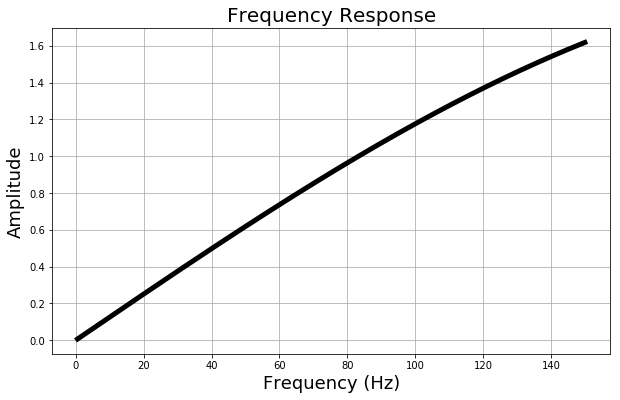

In [14]:
# Generate frequecy grid
f = np.linspace(0.5, 150, 2048)
fs = 1000

omega = f*2*np.pi/fs

# Generate frequency response
freq_resp = 2*abs(np.sin(omega))

# plot
plt.figure(figsize=(10, 6))
plt.plot(f, freq_resp, color='black', linewidth=5)
plt.axis('tight')
plt.title("Frequency Response", fontsize=20)
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("Amplitude", fontsize=18)
plt.grid()
plt.show()

Abaixo estão definidas as funções que implementam cada um dos dois blocos descritos acima.

In [15]:
def central_diff(x):
    """
    Apply celtral diference to signal x[n].
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the signal to be processed.
    
    Returns
    -------
    d : array_like
        One dimensional signal with the same dimensions of x, result from
        first difference : d[n] = x[n+1]-x[n-1]
    """
    
    # Length x
    N = len(x)

    # diff
    diff = np.zeros(N)

    # Aproximate first diference fs/2*(x[t+1]-x[t-1])
    for t in range(1, N-1):
        diff[t] = (x[t+1]-x[t-1])

    return diff

def hilbert_transform(x):
    """
    Apply Hilbert transform to signal x[n]
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the signal to be processed.
    
    Returns
    -------
    y : array_like
        One dimensional signal with the same dimensions of x, result from
        apply hilbert transform to x.
    """
    
    return np.imag(sgn.hilbert(x))

<a id='QRSex'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### c) Exemplo de aplicação

A seguir o procedimento para realçar o complexo QRS será aplicado em um sinal real de eletrocardiograma. 
Abaixo estão mostrados o sinal $x[n]$, a diferença desse sinal, $d[n]$, e por fim o resultado da 
transformada Hilbert, $y[n]$.
Note que para o sinal $y[n]$ o complexo QRS é destacado enquanto a onda P é atenuada. Isso evita que o pico da onda R seja
confundido com uma onda P de alta amplitude por exemplo.

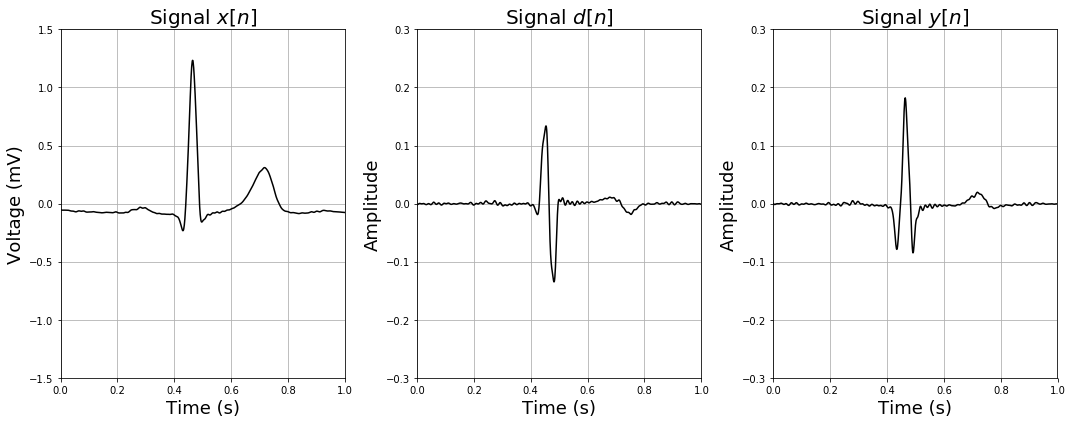

In [16]:
# Load signal
sample2 = np.load("data/sample2.npz")
x = sample2['x']
fs = sample2['fs']

# Generate time vector
t = np.arange(len(x))*1/fs

# Apply central diference
d = central_diff(x)

# Apply hilbert transform
y = hilbert_transform(d)

# Plot signal
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
tmax = max(t[1:1000])
ax[0].plot(t[1:1000], x[1:1000], 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal $x[n]$", fontsize=20)
ax[0].axis([0, tmax, -1.5, 1.5])
ax[0].grid()
ax[1].plot(t[1:1000], d[1:1000], 'k')
ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Signal $d[n]$", fontsize=20)
ax[1].axis([0, tmax, -0.3, 0.3])
ax[1].grid()
ax[2].plot(t[1:1000], y[1:1000], 'k')
ax[2].set_ylabel("Amplitude", fontsize=18)
ax[2].set_xlabel("Time (s)", fontsize=18)
ax[2].set_title("Signal $y[n]$", fontsize=20)
ax[2].grid()
ax[2].axis([0, tmax, -0.3, 0.3])

plt.tight_layout()
plt.show()

<a id='findRpeaks'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.2) Detecção do pico de R

#### a) Procedimento

O sinal $y[n]$, onde o complexo QRS está destacado, será usado para auxiliar a detecção dos picos de R.
O procedimento usado segue os seguintes passos:

* **Primeiro Passo:** Encontra os picos na função $y[n]$. Esses picos devem ser maiores do que uma amplitude mínima $m$ e devem respeitar uma distância mínima $l$ entre eles. A implementação que foi usada para detectar os picos do sinal $y[n]$ é semelhante a função findpeaks do matlab e pode ser encontrada em [http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb). 

* **Segundo Passo:** A região entorno dos picos identificados de $y[n]$ é a região provável para os picos de R. Dessa forma seja $n_0$ o momento de ocorrência de um pico em $y[n]$. O pico de R em $x[n]$ estará  contido no interva-lo $\big(n_0-\epsilon \le n\le n_0+\epsilon\big)$. O pico de R será o maior pico desse interva-lo.

Abaixo está implementada uma função que encontra os picos de R dado o sinal realçado $y[n]$ e o sinal original $x[n]$

In [17]:
def find_Rpeaks(x, y, interval, minimum_peak_height, minimum_peak_distance):
    """
    Find R Peaks using enhanced signal.
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the original ECG signal.
    y : array_like
        One dimensional array containing the signal with enhanced QRS complex.
    minimum_peak_height : float
        Minimum height the signal $y$ should have to be considered a R peak
    minimum_peak_distance : float
        Minimum distance between R peaks
    inteval : float
        Maximum distance to look for a R peak (on x) near an peak an y peak
        
    Returns
    -------
    Rpeaks : array_like
        List containing the R peaks positions on x
    ypeaks : array_like
        List containing the peaks positions on y
    """
    
    # step 1)  Look for peaks on y[n]
    ypeaks = detect_peaks(y, mph=minimum_peak_height, mpd=minimum_peak_distance)
    
    # step 2) Look for R peaks near the ones founds for y[n]
    
    # Fill with NaNs the positions of a new array
    x_near_ypeaks = np.full(x.shape, np.nan);
    
    # Fill only positions near the y peaks
    for p in ypeaks:
        x_near_ypeaks[p-interv:p+interv] = x[p-interv:p+interv]
        
    # detect only peaks near y peaks
    Rpeaks = detect_peaks(x_near_ypeaks)
    
    return Rpeaks, ypeaks

<a id='findRpeaks_example'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Exemplo de aplicação

O procedimento descrito acima está ilustrado abaixo em duas figuras. Na primeira delas estão mostrados os picos detectados para o sinal $y[n]$. Na figura seguinte estão mostrados os picos de R detectados em $x[n]$.

Os parametros usados estão escritos abaixo em função da frequência de amostragem ($f_s = 1000\text{Hz}$):

| Parâmetro |      Descrição               |   Valor  |
|-----------|------------------------------|----------|
|   $l$       | Distância mínima entre picos em $y[n]$ | $0.2~f_s$|
|   $m$       | Altura mínima do pico em $y[n]$ | $0.1$|
|   $\epsilon$       | Distância entre máxima picos em $y[n]$ e $x[n]$ | $0.03~f_s$|

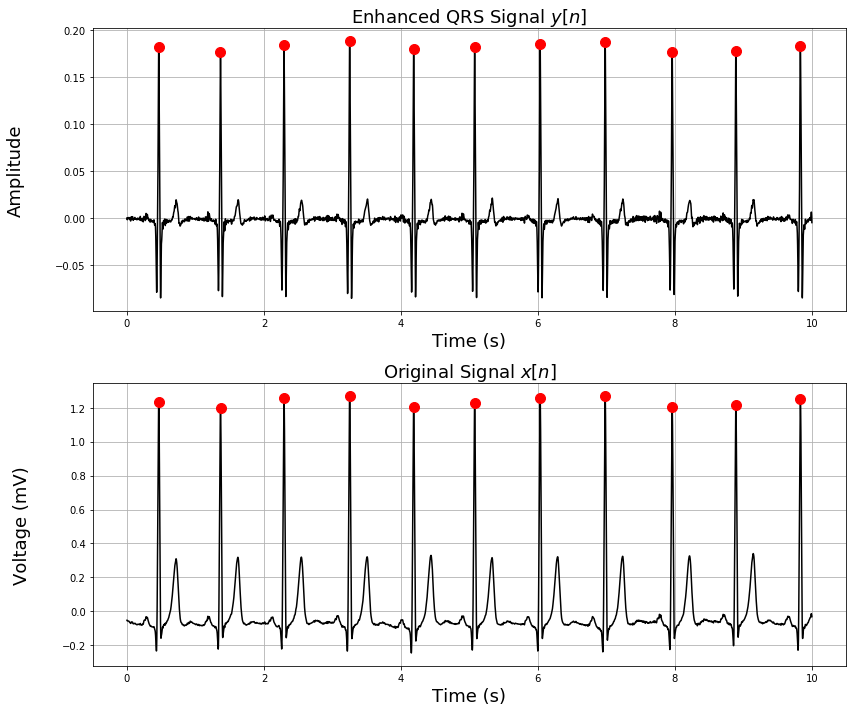

In [18]:
# Parameters for Peak detection
minimum_peak_height = 0.1;
minimum_peak_distance = 0.2*fs
interv  = int(0.03*fs)

# Find R peaks
Rpeaks, ypeaks = find_Rpeaks(x, y, interv, minimum_peak_height, minimum_peak_distance)

# Plot
fig, ax = plt.subplots(2, 1,figsize=(12,10))
ax[0].plot(t, y, 'k')
for p in ypeaks:
    ax[0].plot(t[p], y[p], 'ro', markersize=10)
ax[0].set_ylabel("Amplitude", fontsize=18, labelpad=30)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Enhanced QRS Signal $y[n]$ ", fontsize=18)
ax[0].grid()

ax[1].plot(t, x, 'k')
for p in Rpeaks:
    ax[1].plot(t[p], x[p], 'ro', markersize=10)
ax[1].set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Original Signal $x[n]$", fontsize=18)
ax[1].grid()

plt.tight_layout()
plt.show()

<a id='findRpeaks_coments'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### c) Comentários
* Esse procedimento proposto por [[6]](#ref) é bem mais robusto que simplesmente procurar os picos da onda R no sinal original $x[n]$. Ele evita confundir a onda R com ondas P e T de alta amplitude. Para exemplificar isso, abaixo está mostrado o exemplo de um ECG com ondas T de alta amplitude e os respectivos picos de R encontrados (corretamente!) pelo algorítmo descrito acima.
* O ruído de alta frequência também será amplificado por esse método junto com o complexo QRS. Dessa forma se o sinal do eletrocardiograma estiver corrompido demais com ruído de alta frequência este método pode ter problemas. Apesar disso, para um ECG bem feito, os níveis de ruído de alta frequência não serão um problema.
* Em [[6]](#ref) o autor do procedimento relata um índice bem alto de acerto no banco de dados MIT-BIH ,o qual muito artigos de *feature extraction* de ECG usam como *benchmark*.
* Por fim, um problema grave desse método proposto em [[6]](#ref) é que ele é extremamente dependente de parâmetros $m$, $l$ e $\epsilon$. Esses parâmetros são escolhidos de escolhidos de maneira completamente empirica e o valor ótimo desses valores pode variar consideravelmente se considerarmos dois conjuntos de dados diferentes. Consideraremos um método mais robusto de determinar esses parâmetros a seguir.

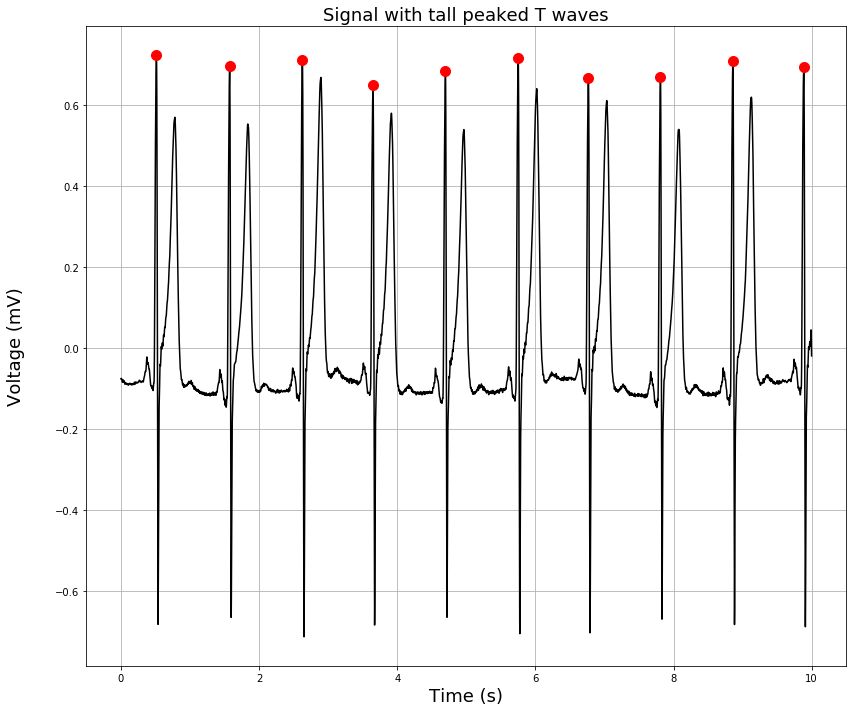

In [19]:
# Load signal
sample3 = np.load("data/sample3.npz")
x_ = sample3['x']
fs_ = sample3['fs']

d_ = central_diff(x_)
y_ = hilbert_transform(d_)

# Generate time vector
t_= np.arange(len(x))*1/fs

# Find R peaks
Rpeaks_, ypeaks_ = find_Rpeaks(x_, y_, interv, minimum_peak_height, minimum_peak_distance)

# plot
fig, ax = plt.subplots(1, 1,figsize=(12,10))
ax.plot(t_, x_, 'k')
for p in Rpeaks_:
    ax.plot(t_[p], x_[p], 'ro', markersize=10)
ax.set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_title("Signal with tall peaked T waves", fontsize=18)
ax.grid()

plt.tight_layout()
plt.show()

<a id='findRpeaks_acs'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### d) Sequência de Autocorrelação

Seja X[n] um sinal estacionário no sentido amplo, a sequência de autocorrelação é definida como:

$r_{XX}[m] = E\{X[n]X[n+m]\}$

Sendo $E\{\bullet\}$ a esperança matemática. A sequência
de autocorrelação mede a similaridade entre o sinal e uma versão deslocada dele mesmo.

Para uma sequencia $x[n]$ de tamanho limitado N (isso é, $x[n] = 0$, para $n<0$ ou $n>N-1$)
um estimador não polarizado para a auto correlação é:

$$\hat{r}_{xx}[m] = \frac{1}{N-|m|}\sum_{n = 0}^{N-|m|-1}x[n]x[n+|m|]$$

Abaixo está mostrada uma função que implementa calcula estima a sequência de autocorrelação: equivalente a função autocorr do matlab.

In [20]:
def crosscorr(y1, y2, M, normalize=False, numSTD=1.96):
    """ Compute the Cross-Correlation Sequence (CCS) r[m] 
    between two time series y1[n] and y2[n] for -M<=m<=M.
    
    Parameters
    ----------
    y1, y2 : array_like
        One dimensional array containing the two observed time series.
    M : int
        Number of lags the crosscorrelation returns or plots
    normalize: bool, optional
        By default normalize=False. If normalize is True return the 
        crosscorrelation normalized in terms of the standard deviation
        of the signals.
    numSTD : float, optional
        Number of standard deviations used on the confidence limit.
        By default numSTD=1.96
        
    Returns
    -------
    css : array_like
        Cross correlation sequence.
    lags : array_like
        Array of lags corresponding to each value of `css`.
    upperBound : array_like
        Array containing the upper bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one upper bound is provided.
    lowerBound : array_like
        Array containing the lower bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one lower bound is provided.
        
    """

    # Convert to numpy array
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    

    # Get dimensions
    N1 = y1.shape[0]
    N2 = y2.shape[0]

    # Get deterministic crosscorralation between the two series
    c = np.correlate(y2, y1, mode="full")
    c = c[N1-M-1 : N1+M]

    # Normalization factor
    if normalize:
        norm = 1
    else:
        norm = y1.std()*y2.std()

    # Get lags
    lags = np.arange(-1*M, M+1)

    # Compute crosscorr
    css = np.zeros(2*M+1)
    b = np.zeros(2*M+1)
    for i, m in enumerate(lags):
        css[i] = c[i]/(min(N1, N2-m)-max(-m, 0))
        b[i] = numSTD*np.sqrt(norm)/np.sqrt(min(N1, N2-m)-max(-m, 0))

    # Normalize
    if normalize:
        css = css/css[M]

    # Set upper and lower bounds
    upperBound = b
    lowerBound = -1*b

    return css, lags, upperBound, lowerBound



def autocorr(y, M, normalize=False, numSTD=1.96):
    """ 
    Compute the Auto-Correlation Sequence (ACS) r[m]
    of a time series y[n] for -M<=m<=M.
    
    Parameters
    ----------
    y  : array_like
        One dimensional array containing the observed time series.
    M : int
        Number of lags the autocorrelation returns or plots
    normalize: bool, optional
        By default normalize=False. If normalize is True return the 
        crosscorrelation normalized in terms of the standard deviation
        of the signal.
    numSTD : float, optional
        Number of standard deviations used on the confidence interval.
        By default numSTD=1.96
        
    Returns
    -------
    acs : array_like
        Auto correlation sequence.
    lags : array_like
        Array of lags corresponding to each value of `css`.
    upperBound : array_like
        Array containing the upper bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one upper bound is provided.
    lowerBound : array_like
        Array containing the lower bounds to the 
        confidence interval. Has the same size as lags,
        once for each lag one lower bound is provided.
    """

    acs, lags, upperBound, lowerBound = crosscorr(y, y, M, normalize, numSTD)

    return acs, lags, upperBound, lowerBound

<a id='findRpeaks_acs_example'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### e) Exemplo da aplicação - autocorrelação

O nosso sinal do eletrocardiogram não é um sinal estacionário. É útil, porém, estimar a sequencia de autocorrelação desse sinal e usá-la para tentar extrair características médias do sinal.

Abaixo está mostrada a sequencia de autocorrelação para o nosso sinal de exemplo.

Os limites de confiança estão mostrados em preto. A autocorrelação fora do limite de confiança
indicam que existe uma correlação significativa (no sentido estatístico) entre o sinal e sua versão 
deslocada.

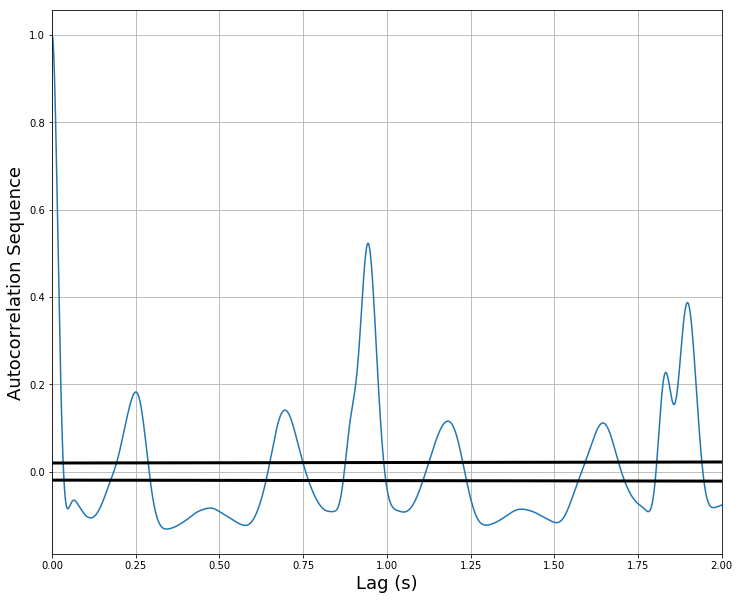

In [21]:
# Compute crosscorrelation sequence for 4 seconds
M = int(2*fs)
acs, lags, upperBound, lowerBound  = autocorr(x, M, normalize=True)
m = lags/fs

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12,10))
ax.plot(m, acs)
ax.plot(m, upperBound, color='k', linewidth=3)
ax.plot(m, lowerBound, color='k', linewidth=3)
ax.set_xlim([0, 2])
ax.set_xlabel("Lag (s)", fontsize=18)
ax.set_ylabel("Autocorrelation Sequence", fontsize=18)

ax.grid()

<a id='findRpeaks_mean'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### f) Características médias do sinal do eletrocardiograma

Usando a auto-correlação é possível obter algumas informações médias do sinal do eletrocardiograma. Dentre elas:

* **Periodo médio do sinal**: O deslocamento para o qual a autocorrelação é máxima pode ser interpretada como o período médio do sinal. Isso porque, um sinal periódico terá a maior similaridade consigo mesmo quando a quantidade do deslocamento for igual ao seu período.

A função abaixo pode ser usada para encontrar o período médio usando a sequência de autocorrelação.

In [22]:
def find_period(x):
    """
    Find sequence mean period using autocorrelation sequence
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing a quasi periodic signal
    
    Returns 
    -------
    period : float
        Sequence mean period.
    """
    
    # Length x
    N = len(x)

    # Crosscorrelation
    r = np.correlate(x, x, "full")

    # normalize
    r = r[N-1:]/r[N-1]

    # Generate lag vector
    lag = np.arange(0, N)

    # Get first local minimum
    localmin_ind = next(x for x in range(1,len(r)-1) if r[x]-r[x-1]<0 and  r[x+1]-r[x]>0)

    # Get global maximum after this minimum
    max_ind = (np.argmax(r[localmin_ind:])+localmin_ind)

    # Global maximum after first minimum is the mean period
    period = max_ind

    return period

<a id='findRpeaks_height_thr'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### g) Usando o período médio para encontrar o *threshold* de altura

O eletrocardiograma pode apresentar frequência variável, de forma que, procurar apenas um pico de R por período 
não seria uma abordagem muito robusta.

Essa abordagem pode ser usada, porém,  para encontrar alguns dos picos. Tendo em vista isso, propomos o 
seguinte procedimento para determinar o *threshold* de altura $m$:

* **Primeiro Passo** : calcular o periodo médio $T$.
* **Segundo Passo** : encontrar um pico do sinal $y[n]$ por período $T$.
* **Terceiro Passo** : calcular a altura média $h_{med}$ desses picos.
* **Quarto Passo** : calcular o valor rms $y_{rms}$ do sinal $y[n]$.
* **Quinto Passo** : usar como threshold de altura:
$$m = \frac{h_{med}+y_{rms}}{2}$$

Ou seja, por esse método consegue-se um threshold de altura que é a média entre o valor rms do sinal $y[n]$ e a amplitude média dos picos de interesse. Essa é uma forma robusta de se calcular o *threshold* de altura $m$. A função abaixo implementa esse procedimento. 

In [23]:
def find_height_threshold(y, period):
    """
    Find height threshold 
    
    Parameters
    ----------
    y : array_like
        One dimensional array contaning signal
    period : number
        Avarege period of $y$ signal
        
    Returns
    -------
    h : float
        Height threshold
    """

    # Step 1) Get period
    
    # Step 2) Find peaks of y with `period` distance between then
    ypeaks = detect_peaks(y, mpd=period-1)
    
    # Step 3) Compute average height
    avg_height = np.mean(y[ypeaks])
    
    # Step 4) Compute RMS value
    y_rms = y.std()
    
    # Step 5) Compute threshold
    h = (avg_height+y_rms)/2
    
    return h

<a id='findRpeaks_params'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### h) Escolha dos parâmetros para detecção do pico de R
Baseado na discussão acima, para a escolha dos parâmetros $m$, $l$ e $\epsilon$ seguem as seguintes diretrizes:
* O parâmetro $l$ pode ser escolhido como uma fração do período médio do sinal (definido no [item f](#findRpeaks_mean)). No [item b](#findRpeaks_example), por exemplo, foi esxolhido $l$ aproximadamente igual a $20\%$ do valor do período médio. Essa escolha de $20\%$ pode ser usada para outros *data sets*.
* O threshold de altura $m$ pode ser calculado usando o procedimento descrito no [item g](#findRpeaks_height_thr).
* O procedimento no geral não é muito afetado pela escolha de $\epsilon$. O valor usado no [item b](#findRpeaks_example)  pode ser usado para análise de outros *data sets* sem maiores problemas.

<a id='QRSonsetoffset'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.3) Detecção do início e do final do complexo QRS

Os pontos que delimitam o início e o final do complexo QRS também são pontos importantes de serem identificados.
Discutiremos aqui um método para detectá-lo.

#### a) Sinal Analítico

Um [sinal analítico](https://en.wikipedia.org/wiki/Analytic_signal) é um sinal que não possui componentes de frequencia negativas. Ou seja, dado um sinal $s[n]$, esse sinal $S(e^{j\omega})$ será analítico se e somente
se:

$$S(e^{j\omega}) = 0,~~  -\pi \le \omega \le 0$$

Note que o sinal $s[n]$ não pode ser um sinal que assume valores complexos, uma vez que todo sinal real $d[n]$, é tal que sua transformada de Fourier respeita a seguinte relação de simetria:

$$D(e^{j\omega}) = D^*(e^{-j\omega})$$

(que não é respeitada por $S(e^{j\omega})$)

#### b) Transformada Hilbert e os Sinais Analíticos

Seja $d[n]$ um sinal real e $D(e^{j\omega})$ sua transformada de Fourier. Vamos definir:

$$s[n] = d[n] + j y[n]$$ 

onde $y[n] = \mathcal{H}\{d[n]\}$ é o sinal obtido tomando a transformada Hilbert de $d[n]$. Não 
é difícil de provar que a transformada de Fourier de $s[n]$ é dada por:

$$S(e^{j\omega}) =
\left\{
\begin{array}{c}
D(e^{j\omega}), ~ 0 < \omega \le \pi\\
0, -\pi < \omega \le 0
\end{array}\right.$$

#### c) Envelope de Sinais

A representação de um sinal como um sinal analítico é uma generalização do conceito de fasor e pode ser interessante definir o modulo e a fase desse sinal tem a interpretação, respectivamente, da amplitude instantânea e da fase instantânea do sinal. Vamos chamar o modulo do sinal analítico $s[n]$ de "envelope":

$$w[n] = \big|s[n]\big|$$

#### d) Envelope da derivada do sinal do ECG
A idéia de utilizar o envelope do sinal de ECG para encontrar o início e o final do complexo QRS pode ser encontrada em [[4]](#ref). Nesse trabalho vamos utilizar o envelope da derivada $d[n]$ do sinal como sinal auxiliar para encontrar o início (*onset*) e o final (*offset*) do complexo QRS.

A obtenção do envelope $w[n]$ para a derivada $d[n]$ do sinal do eletrocardiograma está ilustrada no diagrama de blocos abaixo. 

-----------------
![QRSonsetoffset](img/QRSonsetoffset.png)

------------------

Abaixo está mostrado o sinal $x[n]$ sobreposto ao envelope de sua derivada $w[n]$.

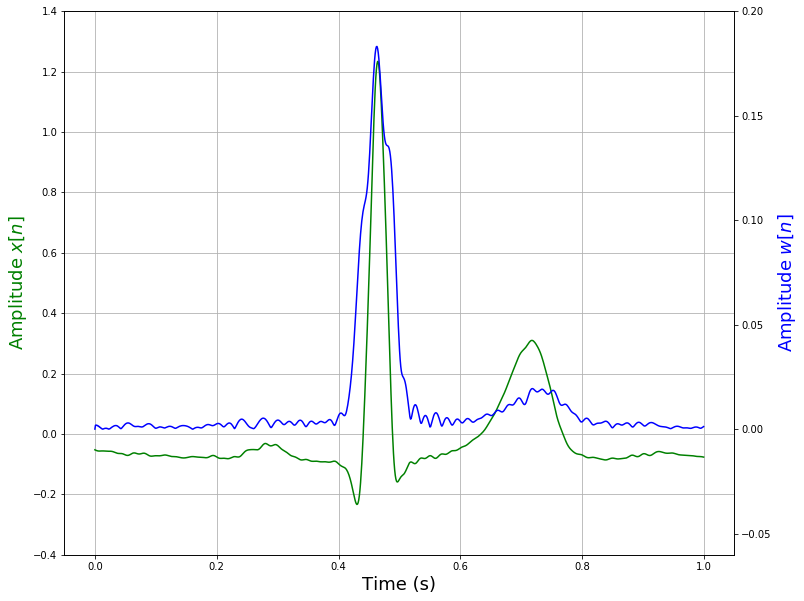

In [24]:
# compute wrapper for the previous example
w = np.sqrt(d**2+y**2)

# Plot
fig, ax1 = plt.subplots(figsize=(12,10))

ax2 = ax1.twinx()
ax1.plot(t[:1000], x[:1000], 'g-')
ax2.plot(t[:1000], w[:1000], 'b-')

ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('Amplitude $x[n]$', color='g', fontsize=18)
ax1.set_ylim([-0.4, 1.4])
ax2.set_ylabel('Amplitude $w[n]$', color='b', fontsize=18)
ax2.set_ylim([-0.06, 0.2])
ax1.grid()
plt.show()

<a id='QRSonsetoffsetalgorithm'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### e) Explicação do método

Seja $n_0$ o momento de ocorrencia de um pico de R. Vamos definir um intervalo 
$\big(n_0-\lambda \le n\le n_0+\lambda\big)$ como uma região grande o suficiente para conter todo complexo QRS, de tal forma que o ponto de início e o ponto de final estejam contidos nesse interva-lo. O ponto de início do complexo QRS (*onset*) é o primeiro ponto, vindo de $n_0$ para a direita, para o qual $w[n] \le \kappa_1$. De forma análoga, o ponto de final do complexo QRS (*offset*) é o primeiro ponto, vindo de $n_0$ para a esquerda, para o qual $w[n] \le \kappa_2$. Abaixo está mostrada uma função que encontra o início e o final do complexo QRS.

In [25]:
def find_onsetoffset(w, peaks, thronset, throffset, interval):
    """
    Find onset and offset points for a given list of peaks.

    Parameters
    ----------
    w : array_like
        An one dimensional array containing the envelope signal.
    peaks : array_like
        Array containing the indeces corresponding to peaks.
    thronset, throffse : float
        Value for which $w[n]$ will be compared in order to find onset and ofset points
    interval : float
        The onset and offset QRS points will be looked for on 
        [n0-interval, n0+interval], for which n0 is the position 
        of an peak.
    
    Returns
    -------
    onsetpt : array_like
        Array containing the indeces corresponding to the onset points
    QRSoffsetpt : array_like
        Array containing the indeces corresponding to the offset points
    """

    # Go through Rpeaks list
    onsetpt = []
    offsetpt = []
    for i, p in enumerate(peaks):
        # Find onset points
        onset = 0
        for n in range(interval):
            if w[p-n] <= thronset:
                break
            onset+=1
        onsetpt.append(p-onset)
        
        # Find offset points
        offset = 0
        for n in range(interval):
            if w[p+n] <= throffset:
                break
            offset+=1
        offsetpt.append(p+offset)
        
    return onsetpt, offsetpt

<a id='QRSonsetoffset_example'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### f) Exemplo de Aplicação

Abaixo está mostrado um exemplo de algorítmo que pode ser usado para detectar o inicio e o final do complexo
QRS. 
Foi plotado o sinal do ECG e foram destacados os picos de R (em **<font color="red"> vermelho </font>**),
os picos de Q (em **<font color="blue"> azul </font>**) e os picos de S (em **<font color="green"> verde </font>**). O início e o final do complexo QRS estão mostrados em **preto**. Foram
usado os 

| Parâmetro |      Descrição               |   Valor  |
|-----------|------------------------------|----------|
|   $\kappa_1$       | Threshold para início do complexo QRS | $0.002$|
|   $\kappa_2$       | Threshold para final do complexo QRS | $0.008$|
|   $\lambda$       | maxima largura | $0.3~f_s$|


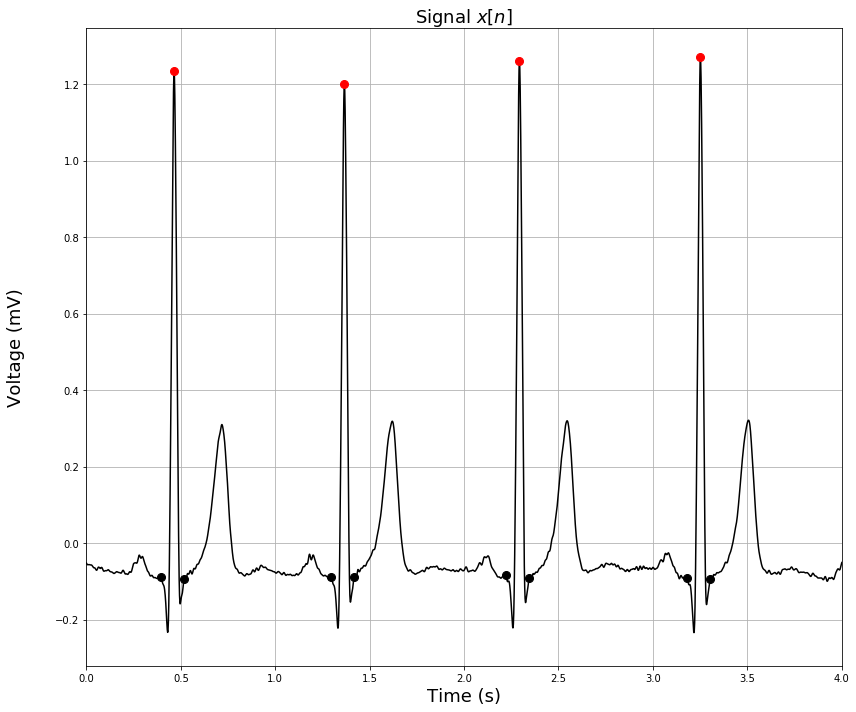

In [26]:
# Define parameters
thronset = 0.002
throffset = 0.008
interval = int(0.3*fs)

QRSonset, QRSoffset = find_onsetoffset(w, Rpeaks, thronset, throffset, interval)

# Plot
fig, ax = plt.subplots(1, 1,figsize=(12,10))
ax.plot(t, x, 'k')
for p in Rpeaks:
    ax.plot(t[p], x[p], 'ro', markersize=8)
for p in QRSonset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
for p in QRSoffset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
ax.set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_title("Signal $x[n]$", fontsize=18)
ax.grid()
ax.set_xlim([0, 4])

plt.tight_layout()
plt.show()

<a id='QRSonsetoffset_params'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### g) Escolha dos Parâmetros
Novamente esse é um caso onde o método depende muito de parâmetros que precisam ser ajustados de maneira empirica. Em [[4]](#ref) os autores usam o envelope do sinal, como foi feito aqui, mas eles escolhem o início e o final do complexo QRS baseado no teste de hipoteses, que é uma forma mais robusta de delimitar esses pontos. 

<a id='findQSpeaks'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.4) Detecção dos picos de Q e de S

#### a) Explicação
Uma vez que o pico de R, o início e o final do complexo QRS já foram encontrados, a detecção dos picos de Q e de S é simples:
Seja $n_0$ o momento de ocorrência de um pico de R, $n_1$ o início do complexo QRS e $n_2$ o final do complexo QRS. O pico de Q é um vale que se encontra no interva-lo $\big(n_1 \le n < n_0 \big)$. O pico de S, por sua vez, é um vale que se encontra no intervalo $\big(n_0 < n\le n_2)$. Os vales (pontos onde ocorre inversão de inclinação) de menor amplitude nesses intervalos serão considerados como os picos de Q e S respectivamente. 

A seguir está mostrada uma função que cálcula os picos de R e de S conhecidos os picos de R e os respectivos início e final do complexo QRS.

In [27]:
def find_QSpeaks(x, Rpeaks, QRSonset, QRSoffset):
    """
    Find onset and offset points for a given list of peaks.

    Parameters
    ----------
    x : array_like
        An one dimensional array containing the ECG signal.
    Rpeaks, QRSonset, QRSoffset : array_like
        Array containing the indeces corresponding to R peaks, QRS onset and offset points
    thronset, QRSoffset : float
        Value for which $w[n]$ will be compared in order to find onset and ofset points

    Returns
    -------
    Qpeaks : array_like
        Array containing the indeces corresponding to the Q peaks
    Speaks : array_like
        Array containing the indeces corresponding to the S peaks
    """

    # a) Detect Q peaks
    x_qpeaks = np.full(x.shape, np.nan);
    for i, p in enumerate(Rpeaks):
        x_qpeaks[QRSonset[i]:Rpeaks[i]] = x[QRSonset[i]:Rpeaks[i]]
    mpd = max(np.array(Rpeaks) - np.array(QRSonset))
    Qpeaks = detect_peaks(x_qpeaks,mpd = mpd, valley=True)


    # b) Detect S peaks
    x_speaks = np.full(x.shape, np.nan);
    for i, p in enumerate(Rpeaks):
        x_speaks[Rpeaks[i]:QRSoffset[i]] = x[Rpeaks[i]:QRSoffset[i]]
    mpd = max(np.array(QRSoffset) - np.array(Rpeaks))
    Speaks = detect_peaks(x_speaks,mpd = mpd, valley=True)
        
    return Qpeaks, Speaks

<a id='findQSpeaks_ex'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Exemplo de Aplicação

Abaixo está mostrado um exemplo de algorítmo que pode ser usado para detectar os picos de Q e de S. 
Foi plotado o sinal do ECG e foram destacados os picos de R (em **<font color="red"> vermelho </font>**),
os picos de Q (em **<font color="blue"> azul </font>**), os picos de S (em **<font color="green"> verde </font>**) e o início e o final do complexo QRS mostrado em **preto**.

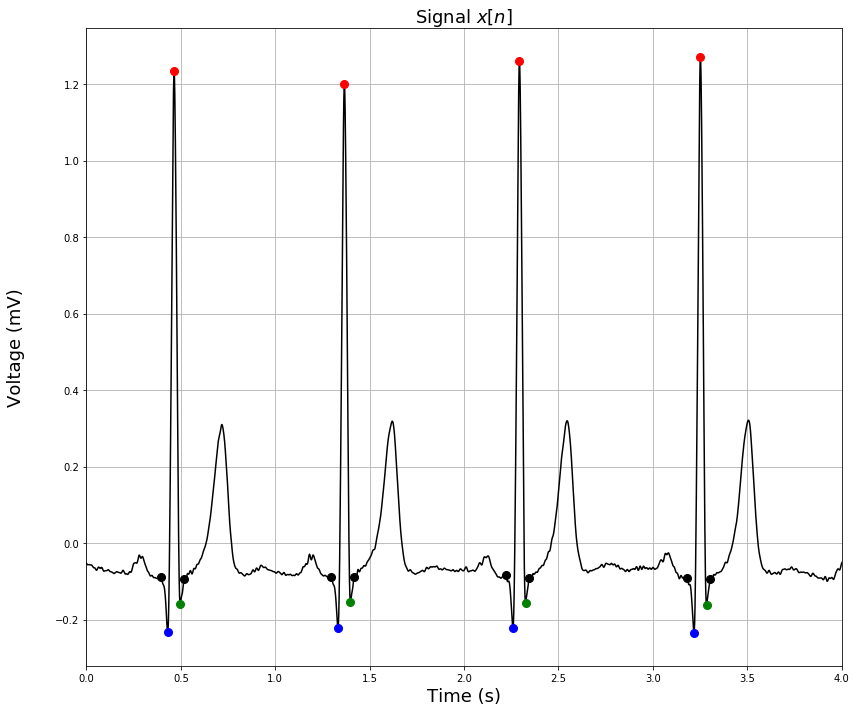

In [28]:
# Find Q and S peaks
Qpeaks, Speaks = find_QSpeaks(x, Rpeaks, QRSonset, QRSoffset)

# Plot
fig, ax = plt.subplots(1, 1,figsize=(12,10))
ax.plot(t, x, 'k')
for p in Rpeaks:
    ax.plot(t[p], x[p], 'ro', markersize=8)
for p in Qpeaks:
    ax.plot(t[p], x[p], 'bo', markersize=8)
for p in Speaks:
    ax.plot(t[p], x[p], 'go', markersize=8)
for p in QRSonset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
for p in QRSoffset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
ax.set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_title("Signal $x[n]$", fontsize=18)
ax.grid()
ax.set_xlim([0, 4])

plt.tight_layout()
plt.show()

<a id='QRSfinalcoments'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 1.5) Comentários Finais sobre a Detecção do Complexo QRS
#### a) Resumo do método visto até aqui
O diagrama mostrado abaixo resume o método para detecção dos pontos de interesse do diagrama QRS.

--------------------------------
![QRSdetection](img/QRSdetection.png)

------------------------

É importante destacar que ao utilizar sinais auxiliares que destacam algumas características de interesse do sinal e atenuam as outras obtém-se um método mais robusto. Tentar utilizar as próprias características do sinal para determinar os parametros usados na extração das *features* como descrito na [seção (1.2h)](#findRpeaks_params) é outra forma de deixar o método mais geral e mais robusto.

Apesar disso, esse método implementado para detectar o complexo QRS ainda tem o escopo bem limitado como explicaremos melhor a seguir.

#### b) Varias topologias do complexo QRS

O complexo QRS possui varias topologias possíveis como mostrado na figura abaixo. Durante a extração de *features* nos limitamos somente a primeira dessas topologias. Um sistema geral para a detecção do complexo QRS deveria ser capaz de lidar com todas essas topologias, o que com certeza aumenta a complexidade do software necessário.


--------------------------
![QRStypes](img/QRStypes.png)

------------------------

#### c) Um possível sistema mais geral

Abaixo está mostrado o diagrama para um método que reconhecesse todas as topologias mencionadas acima. 

--------------------------
![QRSnewIdea](img/QRSnewIdea.png)

------------------------

Não é muito difícil entender que o envelope $w[n]$ terá um pico em QRS independente do tipo de topologia. Um algorítmo que funcionaria para qualquer tipo de topologia seria o seguinte:
* 1) Detectar os picos do envelope $w[n]$. Esses picos corresponderiam denotam a presença de um complexo QRS.
* 2) Delimitar o início e o final desse complexo QRS (de forma semelhante ao feito na [seção 1.3](#QRSonsetoffset)).
* 3) Delimitar os picos e vales no intervalo encontrado para o complexo QRS.
* 4) Uma vez delimitado os picos e vales presentes no complexo QRS seria possível determinar a localização dos picos de Q, R, S e R' e determinar a topologia do complexo QRS.

<a id='PTwaves'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 2) Detecção das ondas P  e das ondas T

### 2.1) Condicionamento do Sinal

#### a) Explicação do Método

O procedimento que será usado para a detecção das ondas P e T está mostrado abaixo:

--------------------------
![PTdetection](img/PTdetection.png)


------------------------

Como mostrado no diagrama acima, uma vez que o complexo QRS já foi detectado ele será removido para facilitar a análise.

As principais componentes das ondas P e T encontram-se na faixas de frequencia entre $0.5Hz$ e $10Hz$ dessa forma, como mostrado no diagrama acima, um filtro passa faixas com as respectivas frequências de corte será aplicado no sinal. A filtragem será bidirecional para evitar a distorção do sinal.

Abaixo está implementada uma função que remove o complexo QRS do sinal $x[n]$.

In [29]:
def remove_segment(x, onset_list, offset_list):
    """
    Remove segments from a signal x.
    
    Parameters
    ----------
    x : array_like
        One dimensional array containing the signal to be processed.
    onset_list, offset_list : array_like
        List containing the begining and the end from the segments to
        be removed.
        
    Returns
    -------
    v : array_like
        Signal without the undesired signals
    """
    v = x.copy()
    for i in range(len(onset_list)):
        v[onset_list[i]:offset_list[i]] = x[onset_list[i]]
        
    return v

<a id='PTwaves_cond_ex'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

#### b) Exemplo de aplicação

A seguir o procedimento para realçar as ondas P e T será aplicado em um sinal real de eletrocardiograma. 
Abaixo estão mostrados os sinais $x[n]$, $v[n]$ e $q[n]$, definidos como mostrado acima. Será usado um filtro de Butterworth passa faixa de ordem 6 e frequencias de cortes $0.5\text{Hz}$ e $10\text{Hz}$.

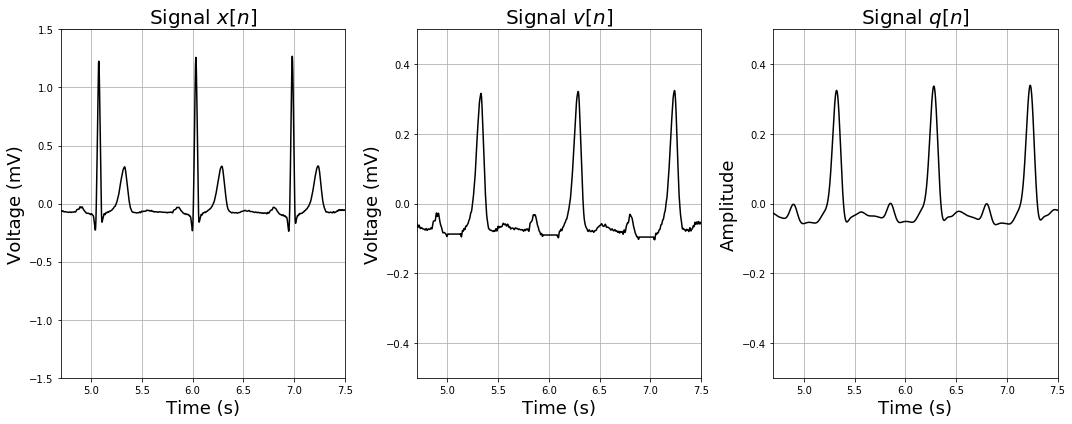

In [30]:
# Remove QRS complex
v = remove_segment(x, QRSonset, QRSoffset)

# Band pass filter
filtord = 3
Wn = [0.5/fs*2, 10/fs*2]
b, a = sgn.butter(filtord, Wn, 'bandpass')

q = sgn.filtfilt(b, a, v)


# Plot signal
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
tmax = max(t)
ax[0].plot(t, x, 'k')
ax[0].set_ylabel("Voltage (mV)", fontsize=18)
ax[0].set_xlabel("Time (s)", fontsize=18)
ax[0].set_title("Signal $x[n]$", fontsize=20)
ax[0].axis([4.7, 7.5, -1.5, 1.5])
ax[0].grid()
ax[1].plot(t, v, 'k')
ax[1].set_ylabel("Voltage (mV)", fontsize=18)
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[1].set_title("Signal $v[n]$", fontsize=20)
ax[1].axis([4.7, 7.5, -0.5, 0.5])
ax[1].grid()
ax[2].plot(t, q, 'k')
ax[2].set_ylabel("Amplitude", fontsize=18)
ax[2].set_xlabel("Time (s)", fontsize=18)
ax[2].set_title("Signal $q[n]$", fontsize=20)
ax[2].grid()
ax[2].axis([4.7, 7.5, -0.5, 0.5])

plt.tight_layout()
plt.show()

<a id='PTwaves_detect'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 2.2) Detecção das ondas P e Q

Abaixo está mostrada a detecção dos picos das ondas P e Q. Eles foram encontrados aplicando as funções "detect_peaks" e "find_onsetoffset" sobre o sinal $q[n]$. 

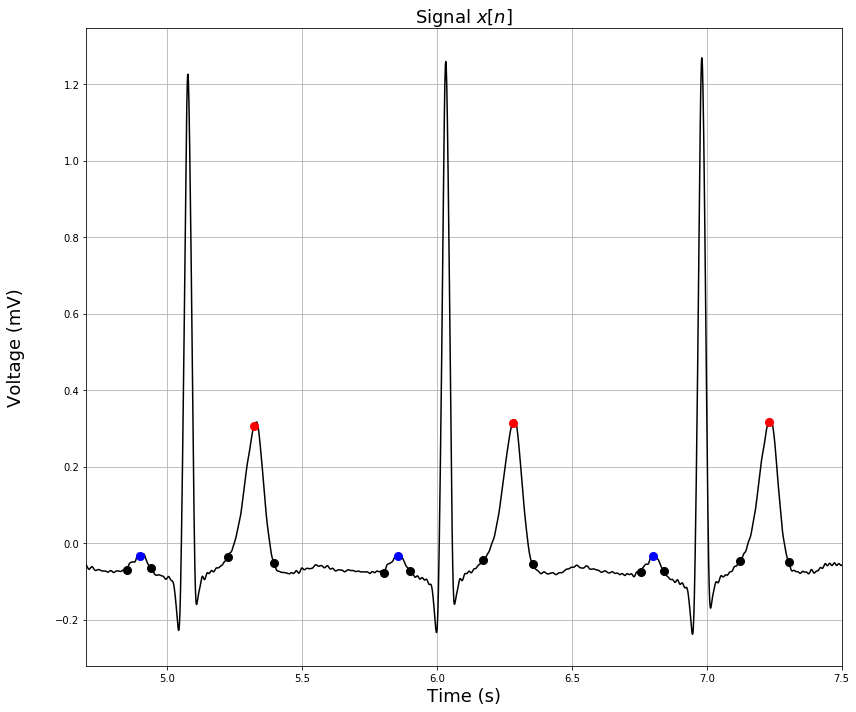

In [31]:
# Find T waves
Tpeaks = detect_peaks(q, mph=0.1, mpd=500)

# Find T wave onset and offset
Tonset, Toffset = find_onsetoffset(q, Tpeaks, -0.01, -0.01, 1000)

# Remove T waves
q2 = remove_segment(q, Tonset, Toffset)

# Find P waves
Ppeaks = detect_peaks(q2, mph=-0.02, mpd=400, edge=None)

# Find P wave onset and offset
Ponset, Poffset = find_onsetoffset(q2, Ppeaks, -0.03, -0.03, 1000)

# Plot
fig, ax = plt.subplots(1, 1,figsize=(12,10))
ax.plot(t, x, 'k')
for p in Tpeaks:
    ax.plot(t[p], x[p], 'ro', markersize=8)
for p in Ppeaks:
    ax.plot(t[p], x[p], 'bo', markersize=8)
for p in Tonset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
for p in Toffset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
for p in Ponset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
for p in Poffset:
    ax.plot(t[p], x[p], 'ko', markersize=8)
ax.set_ylabel("Voltage (mV)", fontsize=18, labelpad=30)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_title("Signal $x[n]$", fontsize=18)
ax.grid()
ax.set_xlim([4.7, 7.5])

plt.tight_layout()
plt.show()

<a id='param'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

## 3) Extração dos Parâmetros

### 3.1) Formando um complexo P-QRS-T representativo

Normalmente na analise computadorizada do ECG forma-se um único complexo P-QRS-T representativo de todo o sinal.
Isso é, sendo o sinal do ECG periodico é possível tomar a média de vários periodos e obter um sinal médio.
Ao fazer isso melhora-se a relação sinal ruído e consegue-se encontrar os pontos característicos do eletrocardiograma de forma mais acurada.

Na figura mostrada abaixo foram sobrepostos varios periodos de um mesmos sinal de um eletrocardiograma, mostrados em plots com cores diversas. Em **preto** está mostrado o sinal médio.

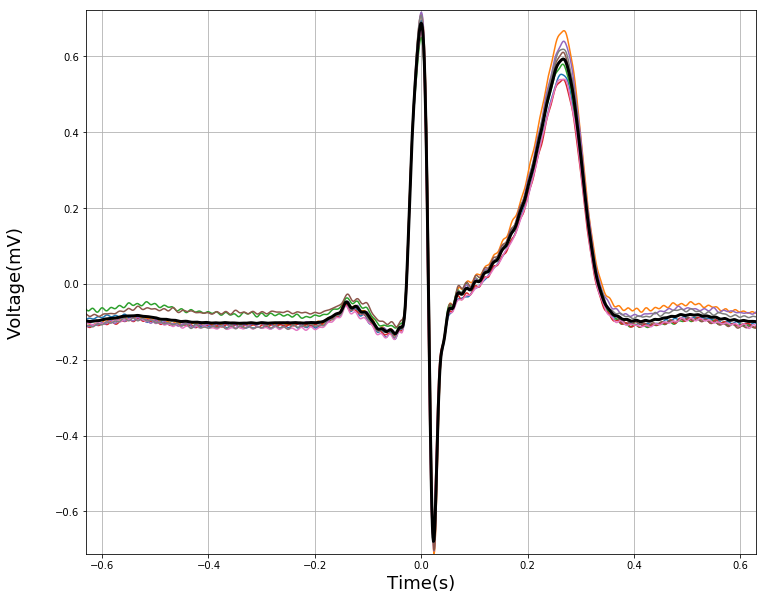

In [32]:
def subdivide_ecg(x, fs, peaks, period):
    # Length x
    N = len(x)

    # Get period lengh in integer units
    P = period

    # find number of periods in a signal
    nperiods = len(peaks)

    interval = []
    start = 0
    end = 0
    for i in range(1,nperiods-1):
        start = peaks[i-1]
        center = peaks[i]
        end = peaks[i+1]
        interval.append((start, center, end))

    return interval

def plot_entangled_signal(x, fs, interval, period):
    """Plot several signal parts in the same plot"""

    # Find maximum interval
    right_extrem = 0
    left_extrem = 0
    for interv in interval:
        if interv[1]-interv[0] > left_extrem:
            left_extrem = interv[1]-interv[0]

        if interv[2]-interv[1] > right_extrem:
            right_extrem = interv[2]-interv[1]

    left_extrem = left_extrem
    right_extrem = right_extrem


    # Create mean vector
    xmean = np.zeros(right_extrem+left_extrem)

    # Plot
    f, ax = plt.subplots(figsize=(12,10))
    for interv in interval:
        # Get start end and center
        start = interv[0]
        center = interv[1]
        end = interv[2]
        
        # Create time vector
        t = (np.arange(len(x[start:end])) - (center-start))
        plt.plot(t/fs, x[start:end])
        xmean[(left_extrem+min(t)):(left_extrem+max(t)+1)] += x[start:end]/len(interval)

    t = (np.arange(len(xmean)) - left_extrem)
    plt.plot(t/fs, xmean, color='black', linewidth=3)
    ax.set_ylabel("Voltage(mV)", fontsize=18, labelpad=30)
    ax.set_xlabel("Time(s)", fontsize=18)
    ax.axis([-0.6*period, 0.6*period, min(x), max(x)])
    ax.grid()
    
sample3 = np.load("data/sample3.npz")
x_ = sample3['x']
fs_ = sample3['fs']

d_ = central_diff(x_)
y_ = hilbert_transform(d_)

# Generate time vector
t_= np.arange(len(x_))*1/fs_

# Find R peaks
Rpeaks_, ypeaks_ = find_Rpeaks(x_, y_, interv, minimum_peak_height, minimum_peak_distance)
period_ = find_period(x_)    
interval_ = subdivide_ecg(x_, fs_, Rpeaks_, period_/fs_)
plot_entangled_signal(x_, fs_, interval_, period_/fs_)

<a id='obs'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

### 3.2)  Observação

Os sinais de ECG que mostramos até agora possuiam apenas uma morfologia de complexo QRS em toda sua extensão. 
É possível, porém, que o ECG possua mais de uma morfologia de QRS em sua extensão, como mostrado na imagem abaixo.

------------------------
![ECG_PVC](img/ECG-PVC.jpg)

----------------------

Nesse caso é importante, antes de encontrar o complexo P-QRS-T representativo médio, fazer uma clasificação dos tipos de QRS presente e fazer um média para cada uma das famílias de complexo presentes.

### 3.3) Medições de Tempos e Amplitudes

Do complexo P-QRS-T representativo do eletrocardiogram podem ser encontradas as posições dos pontos principais (Os algorítmos para extrair esses pontos são os mesmos descritos nas seções [1](#detection) e [2](#PTwaves)). Esses pontos do ECG podem ser usado para fazer medidas do ECG.
Algumas medições de interesse estão mostradas na figura abaixo.

------------------------
![events](img/events.png)

---------------------------

<a id='concl'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

# IV - Conclusão

Neste trabalho foram implementados vários métodos usados para processamento e detecção de pontos principais do ECG. É importante destacar que o foco desse trabalho foram métodos que usam apenas uma derivação para a detecção dos pontos principais.  

Como foi dito na introdução o exame do eletrocardiogram geralmente fornece 12 derivações. Existe alguma redundância entre essas e é possível e eficiente usar informações de todas as derivações na hora de cálcular os pontos de interesse.

Para se fazer isso normalmente utiliza-se uma formulação conhecida como *vectorcardiograma*. Nessa formulação,
as 12 derivações são usada para calcular um vetor $(X[n], Y[n], Z[n])$ que contém a informação espacial sobre os impulsos elétricos cardiacos. Geralmente nesse caso o módulo da derivada desse vetor é usado para tentar encontrar os pontos de interesse e muito dos métodos explicados na seção [1](#detection) ainda podem ser usados.

As medidas e pontos obtidos a partir da análise descrita nesse trabalho podem ser usadas para auxiliar um médico a fazer um diagnóstico ou serem a entrada para um outro estágio de análise computacional, que vai tentar interpretar o ECG e procurar por possíveis anormalidades e patologias.

Cada uma das ondas e complexos do ECG podem assumir muitas polaridades e morfologias diferentes. Dessa forma, um software para reconhecimento de *features* pode chegar a ser bem mais elaborado do que os algorítmos propostos aqui. Mesmo assim, as idéias básicas apresentadas (de utilizar sinais auxiliares que realçam características de interesse e de utilizar as características do próprio sinal para a determinação de *thresholds*) são necessárias na construção de qualquer sistemas robustos de detecção.

<a id='agrad'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

# Agradecimentos
Agradeço ao Centro de Telessaúde do Hospital das Clinícas de Minas Gerais por ter disponibilizado os dados para esse trabalho.

<a id='ref'></a>

[$\uparrow~$Índice$~\uparrow$](#tableofcontent)

# Referências
* [1] [Sophocles J. Orfanidis, "Introduction To Signal Processing", Prentice-Hall, 1996](http://www.ece.rutgers.edu/~orfanidi/intro2sp/orfanidis-i2sp.pdf)
* [2] [Mortara, David W. "Digital filters for ECG signals." Computers in Cardiology (1977): 511-514]() 
* [3] [Macfarlane, Peter W., and Thomas Davidson Veitch Lawrie. Comprehensive electrocardiology: theory and practice in health and disease. Vol. 4, Cap. 37,  Pergamon, 1989.](http://www.springer.com/us/book/9781848820456)
* [4] [A. I. Manriquez and Q. Zhang, "An algorithm for QRS onset and offset detection in single lead electrocardiogram records," 2007 29th Annual International Conference of the IEEE Engineering in Medicine and Biology Society, Lyon, 2007, pp. 541-544.](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=4352347&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D4352347)
* [5] [Sahambi JS, Tandon SN, Bhatt RKP (1997) Using wavelet transforms  for ECG characterization. An on-line digital signal processing system. Engineering in Medicine and BiologyMagazine, IEEE 16: 77-83.](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=566158&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D566158)
* [6] [D. Benitez et. al., "The use of the Hilbert transform in ECG signal analysis", Computers in Biology and Medicine (2001): 399-406](http://www.sciencedirect.com/science/article/pii/S0010482501000099)